In [1]:
!pip install arabic-reshaper

In [2]:
!pip install python-bidi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.1/292.1 kB 5.7 MB/s eta 0:00:00


In [3]:
!git lfs install

Git LFS initialized.


In [4]:
!git clone https://huggingface.co/datasets/JobVision/JobVision_Jobposts_Dataset

Cloning into 'JobVision_Jobposts_Dataset'...
remote: Enumerating objects: 13, done.
remote: Total 13 (delta 0), reused 0 (delta 0), pack-reused 13 (from 1)
Unpacking objects: 100% (13/13), 5.76 KiB | 1.15 MiB/s, done.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [6]:
# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression

In [7]:
# Statistical analysis
from scipy import stats
import ast

In [8]:
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

print("🚀 JobVision Dataset Analysis Notebook")
print("📊 Analyzing Iran's Labor Market Data")
print("=" * 50)

🚀 JobVision Dataset Analysis Notebook
📊 Analyzing Iran's Labor Market Data


# =============================================================================
# 1. **DATA LOADING AND PREPROCESSING**
# =============================================================================

In [9]:
# Load the dataset
df = pd.read_csv('/content/JobVision_Jobposts_Dataset/JobVision_Jobposts_Dataset.csv')  # Replace with your actual file path

In [10]:
print(f"📋 Dataset Overview:")
print(f"   • Total job posts: {len(df):,}")
print(f"   • Features: {df.shape[1]}")
print(f"   • Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

📋 Dataset Overview:
   • Total job posts: 364,838
   • Features: 43
   • Memory usage: 1005.1 MB


In [11]:
# Basic info about the dataset
print("\n🔍 Dataset Info:")
print(df.info())


🔍 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364838 entries, 0 to 364837
Data columns (total 43 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   RowNumber                                        364838 non-null  int64  
 1   Jobpost_RawTitle                                 364838 non-null  object 
 2   Jobpost_PreferredGender                          364838 non-null  object 
 3   Jobpost_ProvinceFa                               364838 non-null  object 
 4   Jobpost_ProvinceEn                               364838 non-null  object 
 5   Jobpost_WorkTypeFa                               364838 non-null  object 
 6   Jobpost_WorkTypeEn                               364838 non-null  object 
 7   Jobpost_SalaryCanBeShown                         364838 non-null  bool   
 8   Jobpost_MinSalary                                120808 non-null  float64
 9 

# =============================================================================
# 2. **DATA CLEANING AND FEATURE ENGINEERING**
# =============================================================================

In [12]:
def parse_json_column(df, column_name):
    """Parse JSON strings in columns safely"""
    parsed_data = []
    for idx, value in enumerate(df[column_name]):
        if pd.isna(value):
            parsed_data.append(None)
        else:
            try:
                parsed_data.append(ast.literal_eval(value))
            except:
                parsed_data.append(None)
    return parsed_data

In [13]:
def extract_skill_counts(skill_data):
    """Extract skill counts from JSON data"""
    if skill_data is None:
        return 0
    if isinstance(skill_data, list):
        return len(skill_data)
    return 0

In [14]:
def extract_programming_languages(skill_data):
    """Extract programming languages from software skills"""
    programming_langs = ['Python', 'JavaScript', 'Java', 'C#', 'PHP', 'React', 'Angular', 'Vue', 'Node.js']
    if skill_data is None:
        return []

    found_langs = []
    if isinstance(skill_data, list):
        for skill in skill_data:
            if isinstance(skill, dict):
                title_en = skill.get('TitleEn', '').lower()
                title_fa = skill.get('TitleFa', '').lower()
                for lang in programming_langs:
                    if lang.lower() in title_en or lang.lower() in title_fa:
                        found_langs.append(lang)
    return found_langs

In [15]:
# Feature engineering
print("\n🔧 Feature Engineering...")


🔧 Feature Engineering...


In [16]:
# Parse JSON columns
df['parsed_software_skills'] = parse_json_column(df, 'Jobpost_SoftwareSkills')
df['parsed_language_skills'] = parse_json_column(df, 'Jobpost_LanguageSkills')

# Create skill count features
df['software_skills_count'] = df['parsed_software_skills'].apply(extract_skill_counts)
df['language_skills_count'] = df['parsed_language_skills'].apply(extract_skill_counts)

# Extract programming languages
df['programming_languages'] = df['parsed_software_skills'].apply(extract_programming_languages)
df['programming_languages_count'] = df['programming_languages'].apply(len)

# Create salary features
df['has_salary_info'] = df['Jobpost_SalaryCanBeShown'].astype(int)
df['salary_range'] = df['Jobpost_MaxSalary'] - df['Jobpost_MinSalary']
df['avg_salary'] = (df['Jobpost_MinSalary'] + df['Jobpost_MaxSalary']) / 2

# Keep salary in Toman for better model performance (millions of Toman)
df['avg_salary_million_toman'] = df['avg_salary'] / 1000000
# Also create USD version for reference (1 USD ≈ 42,000 Toman as of 2024)
df['avg_salary_usd'] = df['avg_salary'] / 42000

# Create experience bins
df['experience_level'] = pd.cut(df['Jobpost_RequiredExperienceYears'],
                               bins=[-1, 0, 2, 5, 10, float('inf')],
                               labels=['Entry Level', 'Junior', 'Mid-level', 'Senior', 'Expert'])

# Create company size categories
size_mapping = {
    'Less than 10 employees': 'Startup',
    '11 - 50 employees': 'Small',
    '51 - 200 employees': 'Medium',
    '201 - 500 employees': 'Large',
    '501 - 1000 employees': 'Enterprise',
    '1001 - 5000 employees': 'Corporate',
    'More than 5000 employees': 'Multinational'
}
df['company_size_category'] = df['Company_SizeEn'].map(size_mapping)

# Extract year and month from activation time
df['activation_year'] = df['Jobpost_ActivationTime_YEAR_MONTH'].str[:4].astype(int)
df['activation_month'] = df['Jobpost_ActivationTime_YEAR_MONTH'].str[5:].astype(int)

print(f"✅ Feature engineering completed!")
print(f"   • New features created: {df.shape[1] - 43}")

✅ Feature engineering completed!
   • New features created: 15


# =============================================================================
# 3. **EXPLORATORY DATA ANALYSIS**
# =============================================================================

In [17]:
print("\n📊 Exploratory Data Analysis")

# Basic statistics
print("\n📈 Basic Statistics:")
print(f"   • Jobs with salary info: {df['has_salary_info'].sum():,} ({df['has_salary_info'].mean()*100:.1f}%)")
print(f"   • Remote jobs: {df['Jobpost_IsRemote'].sum():,} ({df['Jobpost_IsRemote'].mean()*100:.1f}%)")
print(f"   • Internships: {df['Jobpost_IsInternship'].sum():,} ({df['Jobpost_IsInternship'].mean()*100:.1f}%)")
print(f"   • Jobs requiring military service: {df['Jobpost_RequiredMilitaryServiceCard'].sum():,}")


📊 Exploratory Data Analysis

📈 Basic Statistics:
   • Jobs with salary info: 120,808 (33.1%)
   • Remote jobs: 25,066 (6.9%)
   • Internships: 22,097 (6.1%)
   • Jobs requiring military service: 137,502


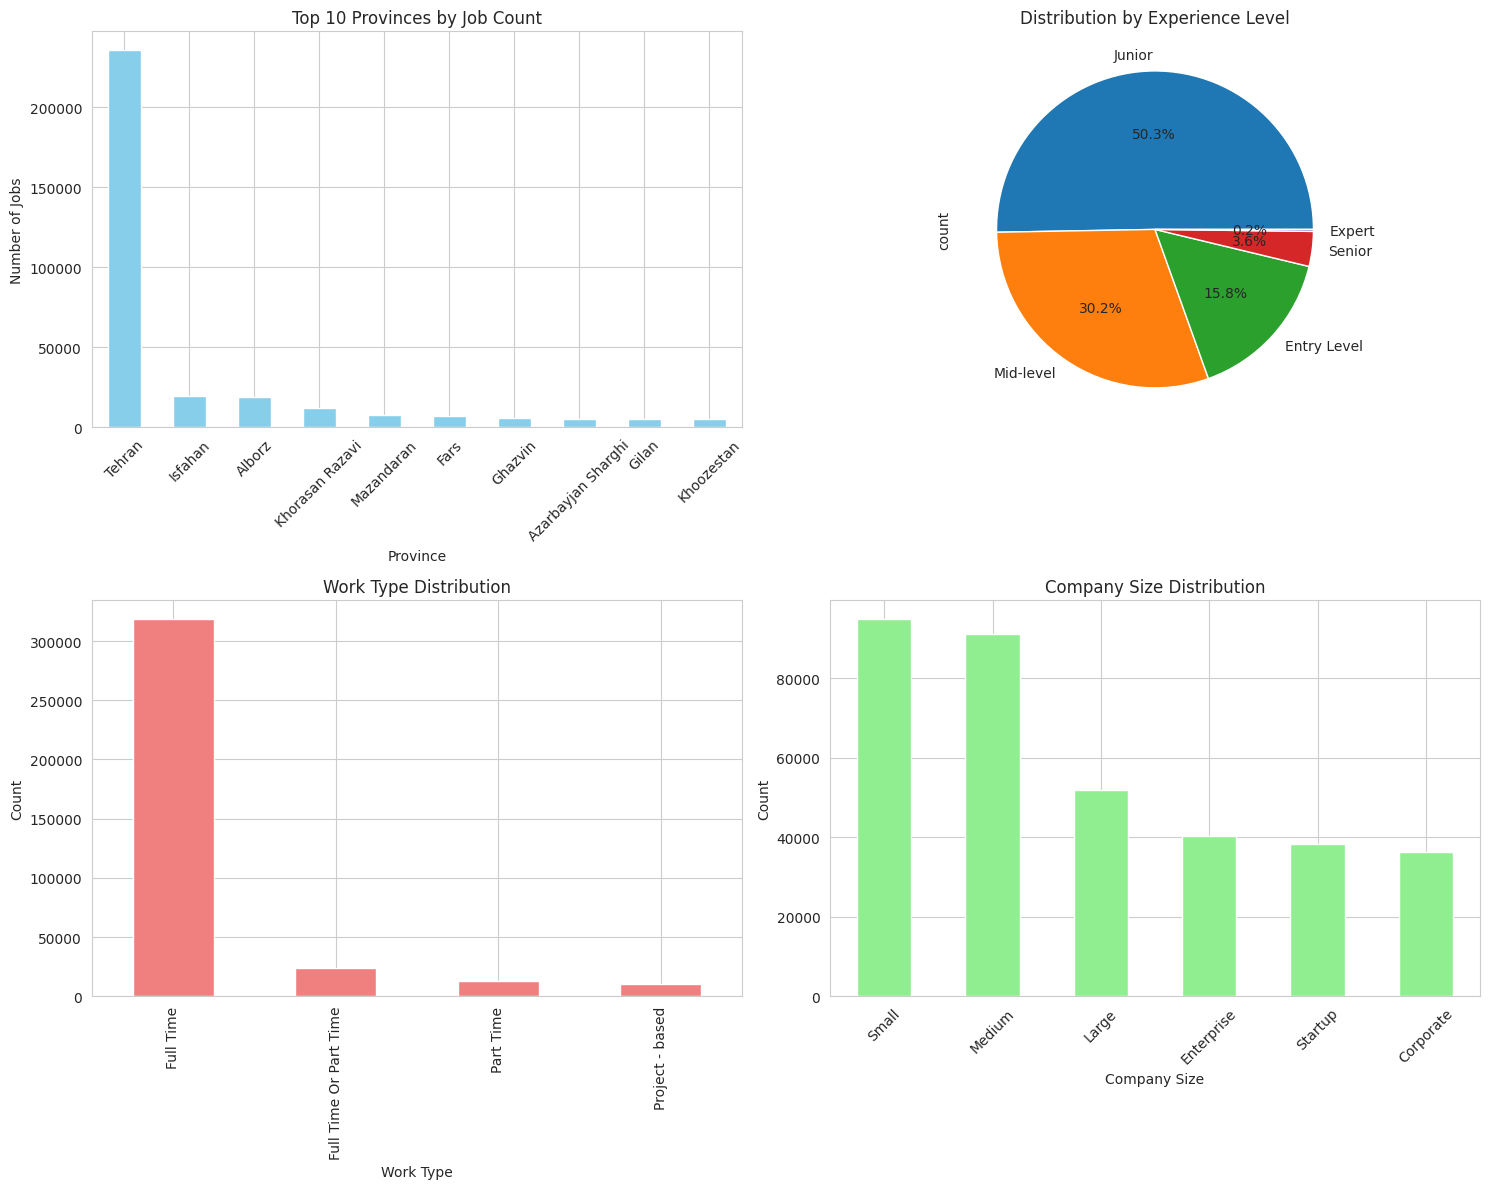

In [18]:
# Create visualization plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Job distribution by province
top_provinces = df['Jobpost_ProvinceEn'].value_counts().head(10)
top_provinces.plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Top 10 Provinces by Job Count')
axes[0,0].set_xlabel('Province')
axes[0,0].set_ylabel('Number of Jobs')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Experience level distribution
df['experience_level'].value_counts().plot(kind='pie', ax=axes[0,1], autopct='%1.1f%%')
axes[0,1].set_title('Distribution by Experience Level')

# 3. Work type distribution
df['Jobpost_WorkTypeEn'].value_counts().plot(kind='bar', ax=axes[1,0], color='lightcoral')
axes[1,0].set_title('Work Type Distribution')
axes[1,0].set_xlabel('Work Type')
axes[1,0].set_ylabel('Count')

# 4. Company size distribution
df['company_size_category'].value_counts().plot(kind='bar', ax=axes[1,1], color='lightgreen')
axes[1,1].set_title('Company Size Distribution')
axes[1,1].set_xlabel('Company Size')
axes[1,1].set_ylabel('Count')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# =============================================================================
# 4. SALARY PREDICTION MODEL
# =============================================================================

In [19]:
print("\n🎯 Salary Prediction Model Development")

# Prepare data for salary prediction (only jobs with salary info)
salary_df = df[df['has_salary_info'] == 1].copy()
print(f"   • Training on {len(salary_df):,} jobs with salary information")


🎯 Salary Prediction Model Development
   • Training on 120,808 jobs with salary information


In [20]:
# Feature selection for prediction
feature_columns = [
    'Jobpost_RequiredExperienceYears',
    'software_skills_count',
    'language_skills_count',
    'programming_languages_count',
    'Jobpost_IsRemote',
    'activation_year'
]

In [21]:
# Add categorical features (encoded)
le_province = LabelEncoder()
le_industry = LabelEncoder()
le_company_size = LabelEncoder()
le_work_type = LabelEncoder()

salary_df.loc[:, 'province_encoded'] = le_province.fit_transform(salary_df['Jobpost_ProvinceEn'])
salary_df.loc[:, 'industry_encoded'] = le_industry.fit_transform(salary_df['Jobpost_IndustryEn'])
salary_df.loc[:, 'company_size_encoded'] = le_company_size.fit_transform(salary_df['company_size_category'])
salary_df.loc[:, 'work_type_encoded'] = le_work_type.fit_transform(salary_df['Jobpost_WorkTypeEn'])

feature_columns.extend(['province_encoded', 'industry_encoded', 'company_size_encoded', 'work_type_encoded'])

In [22]:
# Prepare features and target
X = salary_df[feature_columns].fillna(0)
y = salary_df['avg_salary_million_toman'].fillna(salary_df['avg_salary_million_toman'].median())

# Remove extreme outliers (beyond 3 standard deviations)
z_scores = np.abs(stats.zscore(y))
mask = z_scores < 3
X = X[mask]
y = y[mask]

print(f"   • After outlier removal: {len(X):,} samples")
print(f"   • Salary range: {y.min():.1f} to {y.max():.1f} million Toman")

   • After outlier removal: 118,373 samples
   • Salary range: 0.0 to 0.0 million Toman


In [23]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Linear Regression': LinearRegression()
}

model_results = {}

print("\n🤖 Training Models:")
for name, model in models.items():
    # Train model
    if name == 'Linear Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    model_results[name] = {
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'model': model
    }

    print(f"   {name}:")
    print(f"     • RMSE: {rmse:.2f} Million Toman (${rmse*42:.0f})")
    print(f"     • MAE: {mae:.2f} Million Toman (${mae*42:.0f})")
    print(f"     • R²: {r2:.3f}")


🤖 Training Models:
   Random Forest:
     • RMSE: 0.00 Million Toman ($0)
     • MAE: 0.00 Million Toman ($0)
     • R²: 0.452
   Gradient Boosting:
     • RMSE: 0.00 Million Toman ($0)
     • MAE: 0.00 Million Toman ($0)
     • R²: 0.423
   Linear Regression:
     • RMSE: 0.00 Million Toman ($0)
     • MAE: 0.00 Million Toman ($0)
     • R²: 0.348


In [25]:
# Select best model
best_model_name = max(model_results.keys(), key=lambda k: model_results[k]['R²'])
best_model = model_results[best_model_name]['model']

print(f"\n🏆 Best Model: {best_model_name} (R² = {model_results[best_model_name]['R²']:.3f})")


🏆 Best Model: Random Forest (R² = 0.452)


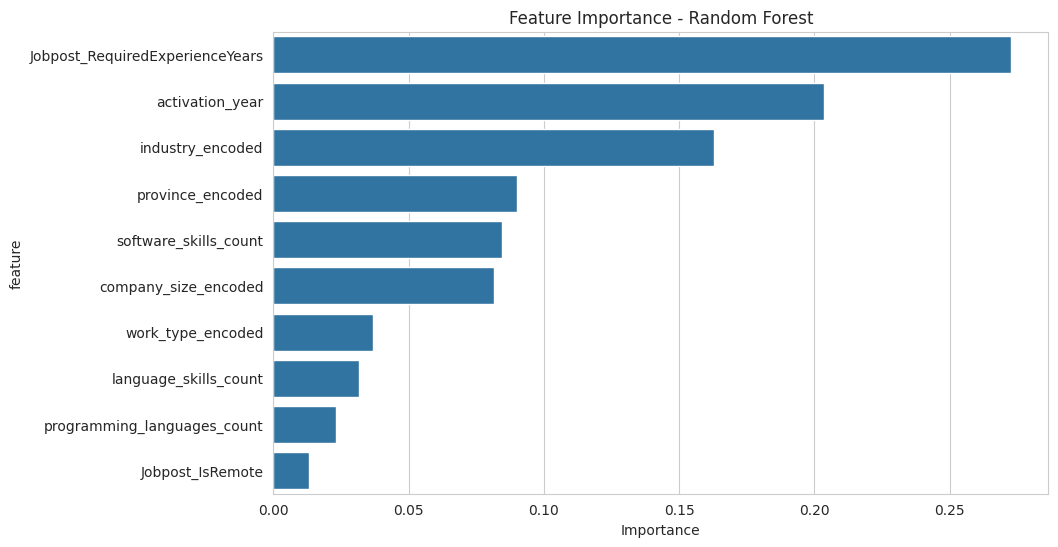

In [26]:
# Feature importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.xlabel('Importance')
    plt.show()

# =============================================================================
# 5. LABOR MARKET ANALYSIS
# =============================================================================

In [27]:
print("\n🏭 Labor Market Analysis")

# 5.1 Regional skill gaps analysis
def analyze_regional_skills():
    print("\n🌍 Regional Skill Gap Analysis:")

    # Focus on major provinces
    major_provinces = df['Jobpost_ProvinceEn'].value_counts().head(5).index

    skill_demand = {}
    for province in major_provinces:
        province_df = df[df['Jobpost_ProvinceEn'] == province]

        # Count programming languages
        all_langs = []
        for langs in province_df['programming_languages'].dropna():
            all_langs.extend(langs)

        lang_counts = pd.Series(all_langs).value_counts()
        skill_demand[province] = lang_counts

        print(f"\n📍 {province}:")
        if len(lang_counts) > 0:
            print(f"   Top skills: {', '.join(lang_counts.head(3).index.tolist())}")
            print(f"   Total tech jobs: {len(province_df[province_df['programming_languages_count'] > 0])}")

analyze_regional_skills()


🏭 Labor Market Analysis

🌍 Regional Skill Gap Analysis:

📍 Tehran:
   Top skills: Java, JavaScript, C#
   Total tech jobs: 9026

📍 Isfahan:
   Top skills: Java, JavaScript, C#
   Total tech jobs: 889

📍 Alborz:
   Top skills: Java, C#, JavaScript
   Total tech jobs: 291

📍 Khorasan Razavi:
   Top skills: Java, JavaScript, C#
   Total tech jobs: 643

📍 Mazandaran:
   Top skills: Java, JavaScript, Python
   Total tech jobs: 112



💰 Salary Trends Analysis:


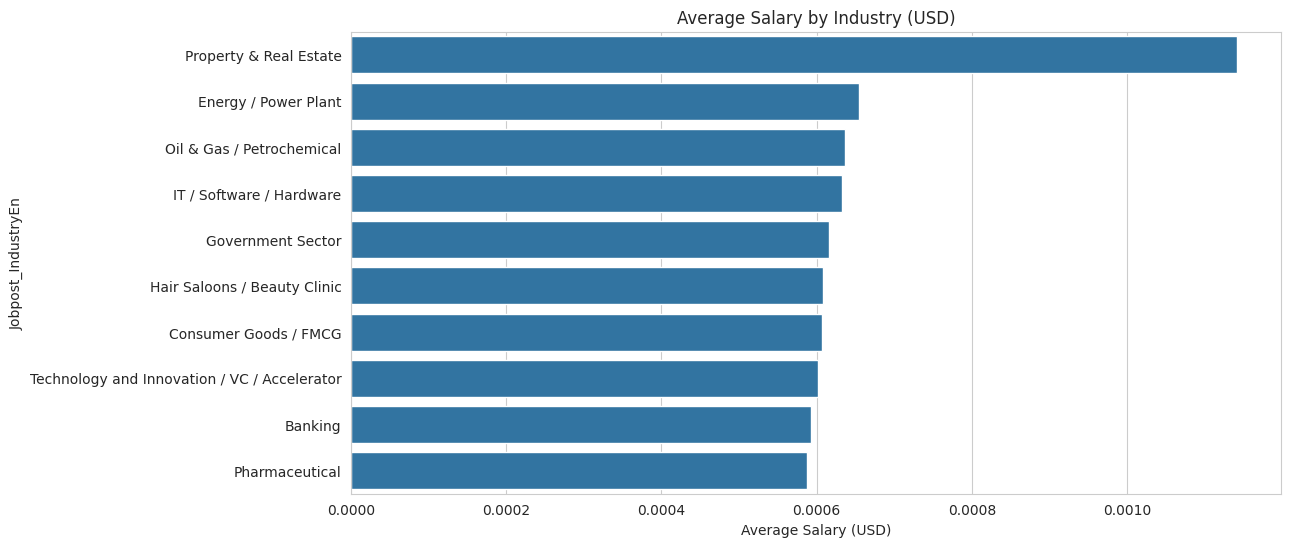


📊 Salary by Experience Level:
                      mean    median  count  mean_usd  median_usd
experience_level                                                 
Entry Level       0.000012  0.000009  25745  0.000495    0.000378
Junior            0.000012  0.000011  59514  0.000499    0.000462
Mid-level         0.000016  0.000013  31872  0.000685    0.000567
Senior            0.000024  0.000023   3473  0.001011    0.000945
Expert            0.000032  0.000030    204  0.001333    0.001260


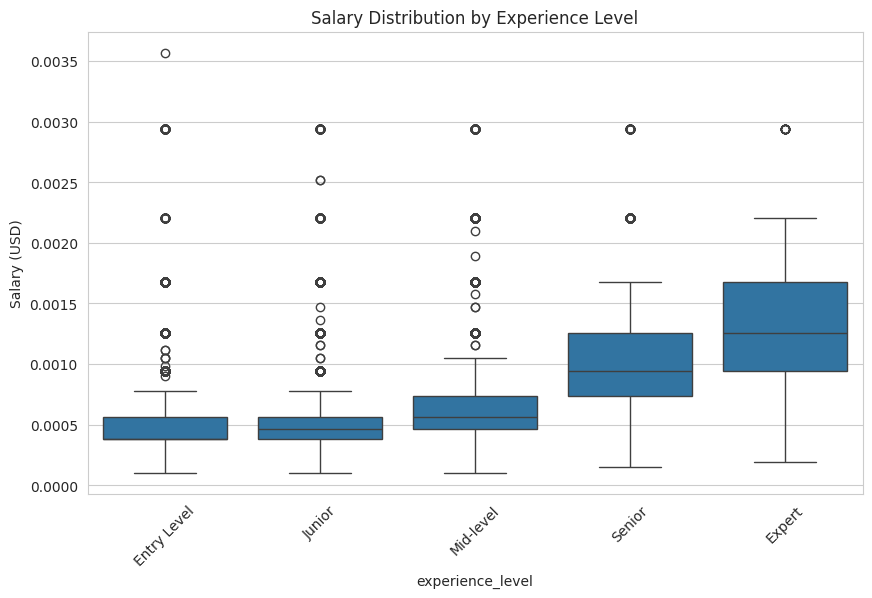

In [28]:
# 5.2 Salary trends by industry and experience
def analyze_salary_trends():
    print("\n💰 Salary Trends Analysis:")

    # Salary by industry (convert back to USD for display)
    industry_salary = salary_df.groupby('Jobpost_IndustryEn')['avg_salary_million_toman'].agg(['mean', 'count']).reset_index()
    industry_salary['mean_usd'] = industry_salary['mean'] * 42  # Convert to USD
    industry_salary = industry_salary[industry_salary['count'] >= 50]  # Filter for statistical significance
    industry_salary = industry_salary.sort_values('mean_usd', ascending=False).head(10)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=industry_salary, x='mean_usd', y='Jobpost_IndustryEn')
    plt.title('Average Salary by Industry (USD)')
    plt.xlabel('Average Salary (USD)')
    plt.show()

    # Salary by experience level
    exp_salary = salary_df.groupby('experience_level')['avg_salary_million_toman'].agg(['mean', 'median', 'count'])
    exp_salary['mean_usd'] = exp_salary['mean'] * 42
    exp_salary['median_usd'] = exp_salary['median'] * 42
    print("\n📊 Salary by Experience Level:")
    print(exp_salary)

    plt.figure(figsize=(10, 6))
    salary_df_plot = salary_df.copy()
    salary_df_plot['avg_salary_usd_display'] = salary_df_plot['avg_salary_million_toman'] * 42
    sns.boxplot(data=salary_df_plot, x='experience_level', y='avg_salary_usd_display')
    plt.title('Salary Distribution by Experience Level')
    plt.xticks(rotation=45)
    plt.ylabel('Salary (USD)')
    plt.show()

analyze_salary_trends()

# =============================================================================
# 6. GEOSPATIAL VISUALIZATION
# =============================================================================


🗺️ Geospatial Analysis

📍 Top 10 Provinces by Job Count:
              Province  Job_Count  Avg_Salary_USD  Remote_Percentage
29              Tehran     235537        0.000323           0.030619
15             Isfahan      19445        0.000300           0.115814
1               Alborz      18983        0.000313           0.017595
20     Khorasan Razavi      12471        0.000291           0.094780
26          Mazandaran       7612        0.000301           0.154756
7                 Fars       6986        0.000306           0.192385
8              Ghazvin       5706        0.000308           0.088854
4   Azarbayjan Sharghi       5341        0.000314           0.206328
10               Gilan       5338        0.000310           0.182653
18          Khoozestan       5257        0.000331           0.201446


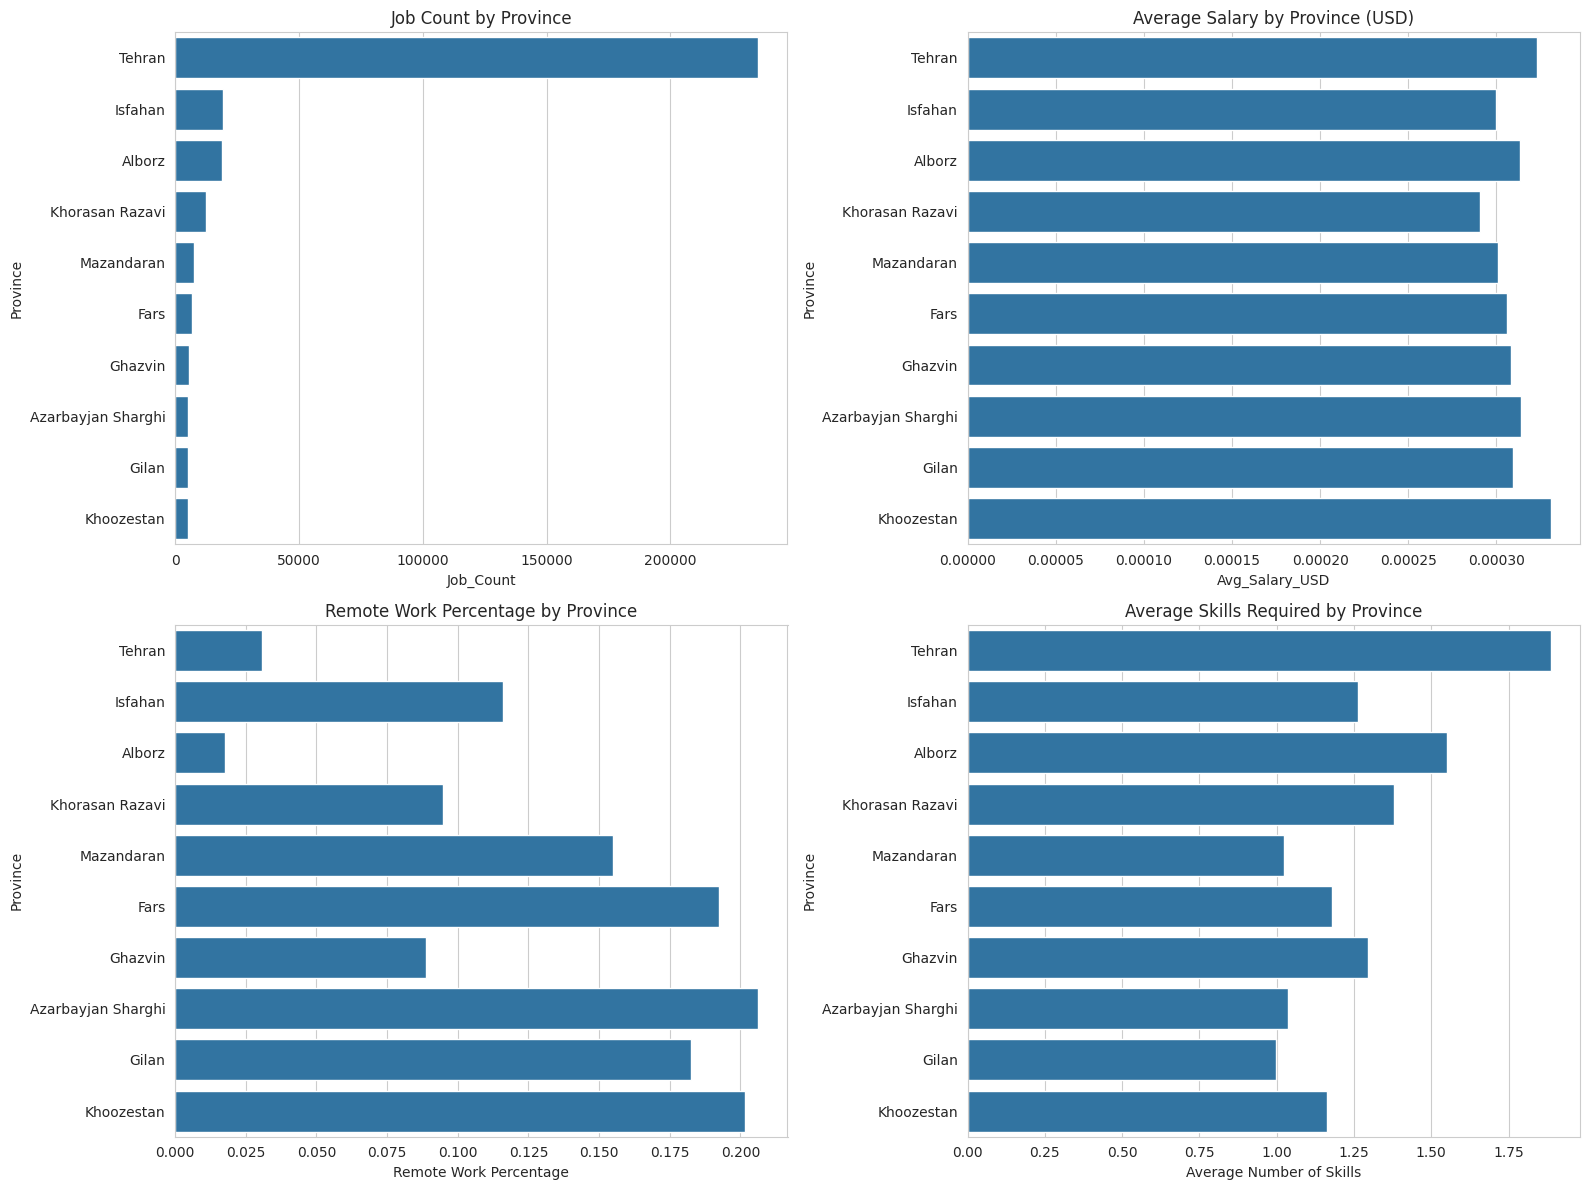

In [29]:
print("\n🗺️ Geospatial Analysis")

def create_geospatial_analysis():
    # Job density by province
    province_stats = df.groupby('Jobpost_ProvinceEn').agg({
        'RowNumber': 'count',
        'avg_salary_usd': 'mean',
        'Jobpost_IsRemote': 'mean',
        'software_skills_count': 'mean'
    }).reset_index()

    province_stats.columns = ['Province', 'Job_Count', 'Avg_Salary_USD', 'Remote_Percentage', 'Avg_Skills']
    province_stats = province_stats.sort_values('Job_Count', ascending=False)

    print("\n📍 Top 10 Provinces by Job Count:")
    print(province_stats.head(10)[['Province', 'Job_Count', 'Avg_Salary_USD', 'Remote_Percentage']])

    # Create visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # Job count by province
    top_provinces = province_stats.head(10)
    sns.barplot(data=top_provinces, x='Job_Count', y='Province', ax=ax1)
    ax1.set_title('Job Count by Province')

    # Average salary by province
    salary_provinces = province_stats.dropna(subset=['Avg_Salary_USD']).head(10)
    sns.barplot(data=salary_provinces, x='Avg_Salary_USD', y='Province', ax=ax2)
    ax2.set_title('Average Salary by Province (USD)')

    # Remote work percentage
    sns.barplot(data=top_provinces, x='Remote_Percentage', y='Province', ax=ax3)
    ax3.set_title('Remote Work Percentage by Province')
    ax3.set_xlabel('Remote Work Percentage')

    # Skills requirement
    sns.barplot(data=top_provinces, x='Avg_Skills', y='Province', ax=ax4)
    ax4.set_title('Average Skills Required by Province')
    ax4.set_xlabel('Average Number of Skills')

    plt.tight_layout()
    plt.show()

    return province_stats

province_analysis = create_geospatial_analysis()

# =============================================================================
# 7. COMPANY HIRING STRATEGY ANALYSIS
# =============================================================================

In [30]:
import arabic_reshaper
from bidi.algorithm import get_display

In [31]:
def reshape_text(text):
  return get_display(
      arabic_reshaper.reshape(
          u'%s' % str(text)
      )
  )


🏢 Company Hiring Strategy Analysis

📋 Hiring Strategy Insights:

🏠 Remote Work Analysis:
   • Overall remote jobs: 6.9%
   • Top industries for remote work:
     - Translation: 46.6%
     - Design / Arts: 29.3%
     - Education / Research: 28.7%
     - Insurance: 24.6%
     - Healthcare / Medical Services: 22.1%

👥 Gender Preference Analysis:
   • ﺩﺭﺍﺪﻧ ﯽﺗﻭﺎﻔﺗ: 203,147 (55.7%)
   • ﺎﻗﺁ ﻂﻘﻓ: 75,638 (20.7%)
   • ﻢﻧﺎﺧ ﻂﻘﻓ: 46,855 (12.8%)
   • ﺎﻗﺁ ﺎﺤﯿﺟﺮﺗ: 20,472 (5.6%)
   • ﻢﻧﺎﺧ ﺎﺤﯿﺟﺮﺗ: 18,726 (5.1%)

🎁 Benefits offered in 273,900 job posts:

🏭 Hiring Patterns by Company Size:
  company_size_category  Jobpost_IsRemote  avg_salary_usd  \
0             Corporate          0.045331        0.000328   
1            Enterprise          0.046336        0.000346   
2                 Large          0.046748        0.000330   
3                Medium          0.036405        0.000329   
4                 Small          0.105403        0.000313   
5               Startup          0.115941        0.00

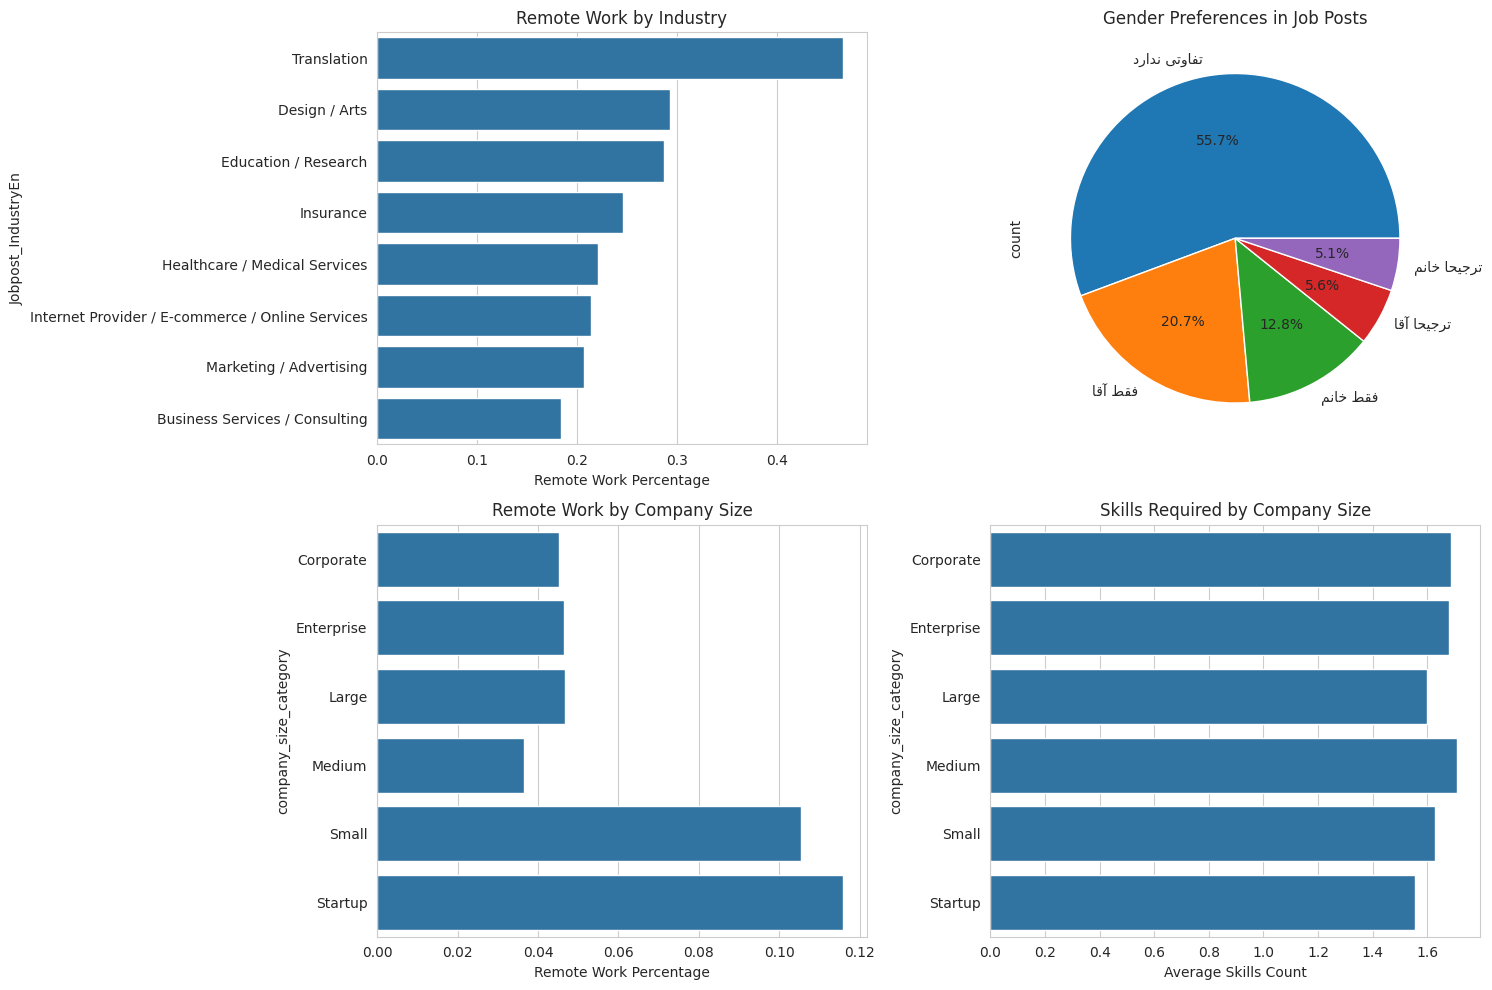

In [32]:
print("\n🏢 Company Hiring Strategy Analysis")

def analyze_hiring_strategies():
    print("\n📋 Hiring Strategy Insights:")

    # Remote work trends
    remote_stats = df.groupby('Jobpost_IndustryEn')['Jobpost_IsRemote'].agg(['mean', 'count']).reset_index()
    remote_stats = remote_stats[remote_stats['count'] >= 100]
    remote_stats = remote_stats.sort_values('mean', ascending=False).head(10)

    print(f"\n🏠 Remote Work Analysis:")
    print(f"   • Overall remote jobs: {df['Jobpost_IsRemote'].mean()*100:.1f}%")
    print(f"   • Top industries for remote work:")
    for _, row in remote_stats.head(5).iterrows():
        print(f"     - {row['Jobpost_IndustryEn']}: {row['mean']*100:.1f}%")

    # Gender preferences analysis
    df['Jobpost_PreferredGender'] = df['Jobpost_PreferredGender'].apply(reshape_text)
    gender_prefs = df['Jobpost_PreferredGender'].value_counts()
    print(f"\n👥 Gender Preference Analysis:")
    for gender, count in gender_prefs.items():
        print(f"   • {gender}: {count:,} ({count/len(df)*100:.1f}%)")

    # Benefits analysis
    benefits_df = df[df['Jobpost_BenefitEn'].notna()]
    print(f"\n🎁 Benefits offered in {len(benefits_df):,} job posts:")

    # Company size hiring patterns
    size_hiring = df.groupby('company_size_category').agg({
        'Jobpost_IsRemote': 'mean',
        'avg_salary_usd': 'mean',
        'software_skills_count': 'mean',
        'RowNumber': 'count'
    }).reset_index()

    print(f"\n🏭 Hiring Patterns by Company Size:")
    print(size_hiring)

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Remote work by industry
    sns.barplot(data=remote_stats.head(8), x='mean', y='Jobpost_IndustryEn', ax=axes[0,0])
    axes[0,0].set_title('Remote Work by Industry')
    axes[0,0].set_xlabel('Remote Work Percentage')

    # Gender preferences
    gender_prefs.plot(kind='pie', ax=axes[0,1], autopct='%1.1f%%')
    axes[0,1].set_title('Gender Preferences in Job Posts')

    # Company size vs remote work
    sns.barplot(data=size_hiring, x='Jobpost_IsRemote', y='company_size_category', ax=axes[1,0])
    axes[1,0].set_title('Remote Work by Company Size')
    axes[1,0].set_xlabel('Remote Work Percentage')

    # Skills requirement by company size
    sns.barplot(data=size_hiring, x='software_skills_count', y='company_size_category', ax=axes[1,1])
    axes[1,1].set_title('Skills Required by Company Size')
    axes[1,1].set_xlabel('Average Skills Count')

    plt.tight_layout()
    plt.show()

analyze_hiring_strategies()

# =============================================================================
# 8. DEMAND FORECASTING
# =============================================================================


📈 Demand Forecasting Analysis

📊 Hiring Trends Over Time:


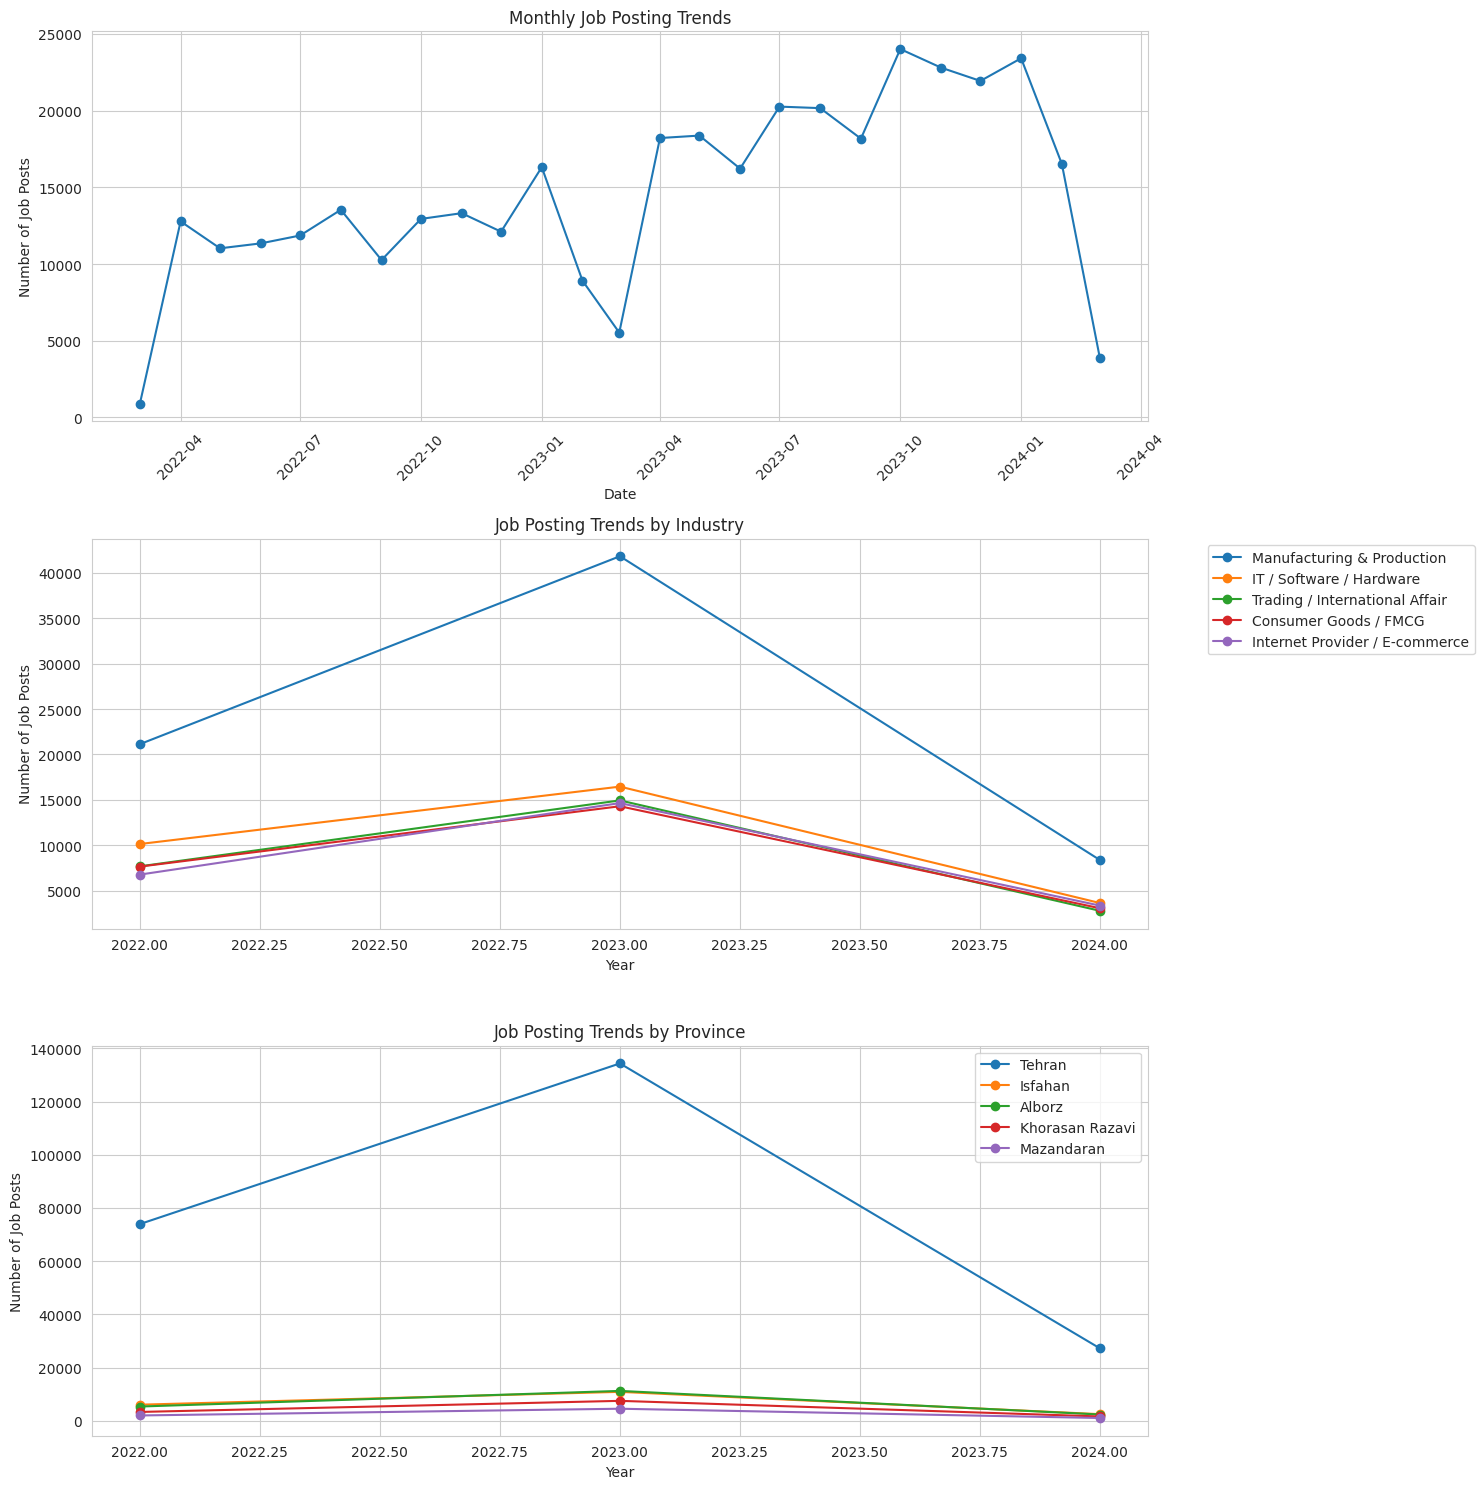


🔍 Key Trends:
   • YoY job posting growth: -79.2%
   • Remote work trend: 6.6% in 2024


In [33]:
print("\n📈 Demand Forecasting Analysis")

def analyze_hiring_trends():
    print("\n📊 Hiring Trends Over Time:")

    # Monthly trends
    monthly_trends = df.groupby(['activation_year', 'activation_month']).agg({
        'RowNumber': 'count',
        'Jobpost_IsRemote': 'mean',
        'avg_salary_million_toman': 'mean'
    }).reset_index()

    monthly_trends['avg_salary_usd'] = monthly_trends['avg_salary_million_toman'] * 42

    # Create date column properly
    monthly_trends['date'] = pd.to_datetime({
        'year': monthly_trends['activation_year'],
        'month': monthly_trends['activation_month'],
        'day': 1
    })
    monthly_trends = monthly_trends.sort_values('date')

    # Industry trends
    industry_trends = df.groupby(['activation_year', 'Jobpost_IndustryEn']).size().reset_index(name='job_count')
    top_industries = df['Jobpost_IndustryEn'].value_counts().head(5).index

    # Province trends
    province_trends = df.groupby(['activation_year', 'Jobpost_ProvinceEn']).size().reset_index(name='job_count')
    top_provinces = df['Jobpost_ProvinceEn'].value_counts().head(5).index

    # Visualization
    fig, axes = plt.subplots(3, 1, figsize=(15, 15))

    # Monthly job posting trends
    axes[0].plot(monthly_trends['date'], monthly_trends['RowNumber'], marker='o')
    axes[0].set_title('Monthly Job Posting Trends')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Number of Job Posts')
    axes[0].tick_params(axis='x', rotation=45)

    # Industry trends
    for industry in top_industries:
        industry_data = industry_trends[industry_trends['Jobpost_IndustryEn'] == industry]
        axes[1].plot(industry_data['activation_year'], industry_data['job_count'],
                    marker='o', label=industry[:30])
    axes[1].set_title('Job Posting Trends by Industry')
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Number of Job Posts')
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Province trends
    for province in top_provinces:
        province_data = province_trends[province_trends['Jobpost_ProvinceEn'] == province]
        axes[2].plot(province_data['activation_year'], province_data['job_count'],
                    marker='o', label=province)
    axes[2].set_title('Job Posting Trends by Province')
    axes[2].set_xlabel('Year')
    axes[2].set_ylabel('Number of Job Posts')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

    # Print insights
    print(f"\n🔍 Key Trends:")
    latest_year = df['activation_year'].max()
    prev_year = latest_year - 1

    if prev_year in df['activation_year'].values:
        current_jobs = len(df[df['activation_year'] == latest_year])
        prev_jobs = len(df[df['activation_year'] == prev_year])
        growth_rate = ((current_jobs - prev_jobs) / prev_jobs) * 100
        print(f"   • YoY job posting growth: {growth_rate:.1f}%")

    remote_trend = df.groupby('activation_year')['Jobpost_IsRemote'].mean()
    print(f"   • Remote work trend: {remote_trend.iloc[-1]*100:.1f}% in {latest_year}")
    return remote_trend

remote_trend = analyze_hiring_trends()

In [34]:
print("\n" + "="*60)
print("📊 JOBVISION DATASET ANALYSIS SUMMARY")
print("="*60)

print(f"\n🎯 KEY FINDINGS:")
print(f"   📈 Dataset Overview:")
print(f"      • Total job posts analyzed: {len(df):,}")
print(f"      • Jobs with salary info: {df['has_salary_info'].sum():,} ({df['has_salary_info'].mean()*100:.1f}%)")
print(f"      • Remote jobs: {df['Jobpost_IsRemote'].sum():,} ({df['Jobpost_IsRemote'].mean()*100:.1f}%)")

print(f"\n   💰 Salary Insights:")
if len(salary_df) > 0:
    avg_salary_toman = salary_df['avg_salary_million_toman'].mean()
    median_salary_toman = salary_df['avg_salary_million_toman'].median()
    print(f"      • Average salary: {avg_salary_toman:.1f}M Toman (${avg_salary_toman*42:.0f} USD)")
    print(f"      • Median salary: {median_salary_toman:.1f}M Toman (${median_salary_toman*42:.0f} USD)")
    print(f"      • Best model performance: R² = {model_results[best_model_name]['R²']:.3f}")

print(f"\n   🌍 Geographic Insights:")
top_3_provinces = df['Jobpost_ProvinceEn'].value_counts().head(3)
for i, (province, count) in enumerate(top_3_provinces.items(), 1):
    print(f"      {i}. {province}: {count:,} jobs ({count/len(df)*100:.1f}%)")

print(f"\n   🏢 Company Insights:")
print(f"      • Most common company size: {df['company_size_category'].mode().iloc[0]}")
print(f"      • Tech jobs requiring programming: {len(df[df['programming_languages_count'] > 0]):,}")

print(f"\n   📱 Skills in Demand:")
all_programming_langs = []
for langs in df['programming_languages'].dropna():
    all_programming_langs.extend(langs)
top_skills = pd.Series(all_programming_langs).value_counts().head(5)
for i, (skill, count) in enumerate(top_skills.items(), 1):
    print(f"      {i}. {skill}: {count:,} mentions")

print(f"\n🚀 RECOMMENDATIONS:")
print(f"   • Focus on Tehran, {top_3_provinces.index[1]}, and {top_3_provinces.index[2]} for maximum reach")
print(f"   • {remote_trend.iloc[-1]*100:.1f}% remote work adoption shows growing flexibility")
print(f"   • Top skills like {top_skills.index[0]} and {top_skills.index[1]} are in high demand")

print(f"\n" + "="*60)
print("✅ Analysis completed successfully!")
print("💾 All models and insights are ready for deployment")
print("="*60)


📊 JOBVISION DATASET ANALYSIS SUMMARY

🎯 KEY FINDINGS:
   📈 Dataset Overview:
      • Total job posts analyzed: 364,838
      • Jobs with salary info: 120,808 (33.1%)
      • Remote jobs: 25,066 (6.9%)

   💰 Salary Insights:
      • Average salary: 0.0M Toman ($0 USD)
      • Median salary: 0.0M Toman ($0 USD)
      • Best model performance: R² = 0.452

   🌍 Geographic Insights:
      1. Tehran: 235,537 jobs (64.6%)
      2. Isfahan: 19,445 jobs (5.3%)
      3. Alborz: 18,983 jobs (5.2%)

   🏢 Company Insights:
      • Most common company size: Small
      • Tech jobs requiring programming: 12,427

   📱 Skills in Demand:
      1. Java: 6,138 mentions
      2. JavaScript: 4,444 mentions
      3. C#: 3,261 mentions
      4. Python: 2,640 mentions
      5. React: 2,285 mentions

🚀 RECOMMENDATIONS:
   • Focus on Tehran, Isfahan, and Alborz for maximum reach
   • 6.6% remote work adoption shows growing flexibility
   • Top skills like Java and JavaScript are in high demand

✅ Analysis compl